## dollar volume bars 

- ajustar automaticamente a la volatilidad del mercado 
- evita sesgos por cambios en el número de acciones, splits o buybaks 
- produce seríes con propiedades estadísticas más estables 



In [10]:
# imports 
# imports 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
# timestamp 
import time

In [11]:
# load data from the csv file 

data = pd.read_csv('../data/processed/BTCUSDT_1m_2024-12-01_to_2025-01-01_cleaned_robust.csv')
data.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote,ignore,mid_price,return
0,2024-12-01 05:01:00,96473.19,96473.19,96464.16,96464.97,2.51941,2024-12-01 05:01:59.999,2.430386e+05,1044.0,0.82286,79377.044051,0.0,96468.675,-0.000085
1,2024-12-01 05:02:00,96464.97,96509.99,96425.70,96509.99,40.57111,2024-12-01 05:02:59.999,3.913119e+06,4030.0,9.65762,931709.380920,0.0,96467.845,0.000467
2,2024-12-01 05:03:00,96509.99,96510.00,96476.00,96480.00,6.33996,2024-12-01 05:03:59.999,6.118070e+05,2520.0,0.81025,78177.723577,0.0,96493.000,-0.000311
3,2024-12-01 05:04:00,96480.01,96480.01,96472.00,96472.00,2.02027,2024-12-01 05:04:59.999,1.949119e+05,603.0,0.10671,10295.342507,0.0,96476.005,-0.000083
4,2024-12-01 05:05:00,96472.00,96472.01,96415.65,96420.02,8.16665,2024-12-01 05:05:59.999,7.875664e+05,2192.0,0.70645,68130.564183,0.0,96443.830,-0.000539


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43138 entries, 0 to 43137
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open_time        43138 non-null  object 
 1   open             43138 non-null  float64
 2   high             43138 non-null  float64
 3   low              43138 non-null  float64
 4   close            43138 non-null  float64
 5   volume           43138 non-null  float64
 6   close_time       43138 non-null  object 
 7   quote_volume     43138 non-null  float64
 8   trades           43138 non-null  float64
 9   taker_buy_base   43138 non-null  float64
 10  taker_buy_quote  43138 non-null  float64
 11  ignore           43138 non-null  float64
 12  mid_price        43138 non-null  float64
 13  return           43138 non-null  float64
dtypes: float64(12), object(2)
memory usage: 4.6+ MB


In [13]:
# convert object adte to datetime 

# ---------- CELDA: conversión robusta de timestamps ----------
import pandas as pd
import numpy as np

# 1) Inspección rápida de la columna
print("dtype original:", data['open_time'].dtype)
print("primeros 10 valores (raw):")
display(data['open_time'].head(10))

# 2) Normalizar strings: strip y reemplazos comunes
# (solo si la columna es de tipo object)
if data['open_time'].dtype == object:
    # eliminar espacios, comillas, saltos de línea
    data['open_time'] = data['open_time'].astype(str).str.strip().str.replace('"', '', regex=False).str.replace("'", "", regex=False)
    data['close_time'] = data['close_time'].astype(str).str.strip().str.replace('"', '', regex=False).str.replace("'", "", regex=False)

# 3) Detectar si la columna es numérica codificada como strings (solo dígitos)
sample_vals = data['open_time'].dropna().astype(str).head(50)
n_digit_samples = sample_vals.apply(lambda x: x.isdigit()).sum()
print(f"de los primeros 50 valores, {n_digit_samples} parecen solo dígitos (epoch)")

# 4) Función que intenta convertir robustamente cada valor (vectorizada)
def robust_to_datetime(series):
    # si ya es datetime, devolver
    if np.issubdtype(series.dtype, np.datetime64):
        return series
    
    s = series.copy()
    # 4a) Si todos (o mayoría) son dígitos -> intentar como epoch ms o s
    as_str = s.dropna().astype(str)
    is_all_digits = as_str.str.match(r'^\d+$').mean()  # proporción de strings sólo dígitos
    
    if is_all_digits > 0.5:
        # la mayoría son timestamps numéricos; inferir ms vs s por magnitud
        # convertir a float para inspección del tamaño (usa sample para evitar overflow)
        sample_num = as_str.sample(min(100, len(as_str))).astype(float)
        median_sample = sample_num.median()
        print("mediana de muestra numérica:", median_sample)
        if median_sample > 1e12:  # típico de ms epoch ( > ~10^12)
            print("-> inferido como epoch en MILLISEGUNDOS")
            out = pd.to_datetime(s.astype(float), unit='ms', errors='coerce')
        elif median_sample > 1e9:  # típico de s epoch ( > ~10^9)
            print("-> inferido como epoch en SEGUNDOS")
            out = pd.to_datetime(s.astype(float), unit='s', errors='coerce')
        else:
            # números pequeños: tratar como strings normalmente
            out = pd.to_datetime(s, errors='coerce')
        return out
    else:
        # 4b) hay muchos strings legibles - intentar parse directo
        # algunos formatos con milisegundos tienen punto decimal: '2024-12-01 05:00:59.999'
        # pd.to_datetime normalmente lo maneja. Usamos errors='coerce' y luego mostraremos fallos.
        out = pd.to_datetime(s, errors='coerce', utc=False)
        # si demasiados NaT, intentar forzar formatos comunes
        nat_frac = out.isna().mean()
        print(f"frac NaT tras parse directo: {nat_frac:.3f}")
        if nat_frac > 0.2:
            # intentar parse con varias plantillas comunes
            fmts = [
                "%Y-%m-%d %H:%M:%S.%f",
                "%Y-%m-%d %H:%M:%S",
                "%Y-%m-%dT%H:%M:%S.%fZ",
                "%Y-%m-%dT%H:%M:%SZ",
            ]
            for fmt in fmts:
                try:
                    test = pd.to_datetime(s, format=fmt, errors='coerce')
                    nat_frac2 = test.isna().mean()
                    print(f"  intento con format {fmt} => NaT frac: {nat_frac2:.3f}")
                    if nat_frac2 < nat_frac:
                        out = test
                        nat_frac = nat_frac2
                except Exception:
                    pass
        return out

# Aplicar la función a open_time y close_time
data['open_time_parsed'] = robust_to_datetime(data['open_time'])
data['close_time_parsed'] = robust_to_datetime(data['close_time'])

# 5) Informar resultados y mostrar ejemplos problemáticos
n_total = len(data)
n_nat_open = data['open_time_parsed'].isna().sum()
n_nat_close = data['close_time_parsed'].isna().sum()
print(f"open_time -> NaT: {n_nat_open}/{n_total} ({n_nat_open/n_total:.3%})")
print(f"close_time -> NaT: {n_nat_close}/{n_total} ({n_nat_close/n_total:.3%})")

if n_nat_open > 0:
    print("Ejemplos de open_time problemáticos:")
    display(data.loc[data['open_time_parsed'].isna(), 'open_time'].head(10))

# 6) Reemplazar columnas originales solo si conversión OK en la mayoría
if (n_nat_open / n_total) < 0.05:
    data['open_time'] = data['open_time_parsed']
else:
    print("Advertencia: demasiados NaT en open_time — revisa los ejemplos anteriores.")
    # no sobrescribimos para evitar pérdida de info

if (n_nat_close / n_total) < 0.05:
    data['close_time'] = data['close_time_parsed']

# borrar columnas auxiliares
data = data.drop(columns=[c for c in ['open_time_parsed', 'close_time_parsed'] if c in data.columns])

# 7) Eliminar filas con open_time NaT si quieres (opcional)
data = data.dropna(subset=['open_time'])

print("Conversión final: dtype open_time =>", data['open_time'].dtype)
display(data.head())


dtype original: object
primeros 10 valores (raw):


0    2024-12-01 05:01:00
1    2024-12-01 05:02:00
2    2024-12-01 05:03:00
3    2024-12-01 05:04:00
4    2024-12-01 05:05:00
5    2024-12-01 05:06:00
6    2024-12-01 05:07:00
7    2024-12-01 05:08:00
8    2024-12-01 05:09:00
9    2024-12-01 05:10:00
Name: open_time, dtype: object

de los primeros 50 valores, 0 parecen solo dígitos (epoch)
frac NaT tras parse directo: 0.000
frac NaT tras parse directo: 0.000
open_time -> NaT: 0/43138 (0.000%)
close_time -> NaT: 0/43138 (0.000%)
Conversión final: dtype open_time => datetime64[ns]


,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote,ignore,mid_price,return
0,2024-12-01 05:01:00,96473.19,96473.19,96464.16,96464.97,2.51941,2024-12-01 05:01:59.999,2.430386e+05,1044.0,0.82286,79377.044051,0.0,96468.675,-0.000085
1,2024-12-01 05:02:00,96464.97,96509.99,96425.70,96509.99,40.57111,2024-12-01 05:02:59.999,3.913119e+06,4030.0,9.65762,931709.380920,0.0,96467.845,0.000467
2,2024-12-01 05:03:00,96509.99,96510.00,96476.00,96480.00,6.33996,2024-12-01 05:03:59.999,6.118070e+05,2520.0,0.81025,78177.723577,0.0,96493.000,-0.000311
3,2024-12-01 05:04:00,96480.01,96480.01,96472.00,96472.00,2.02027,2024-12-01 05:04:59.999,1.949119e+05,603.0,0.10671,10295.342507,0.0,96476.005,-0.000083
4,2024-12-01 05:05:00,96472.00,96472.01,96415.65,96420.02,8.16665,2024-12-01 05:05:59.999,7.875664e+05,2192.0,0.70645,68130.564183,0.0,96443.830,-0.000539


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43138 entries, 0 to 43137
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   open_time        43138 non-null  datetime64[ns]
 1   open             43138 non-null  float64       
 2   high             43138 non-null  float64       
 3   low              43138 non-null  float64       
 4   close            43138 non-null  float64       
 5   volume           43138 non-null  float64       
 6   close_time       43138 non-null  datetime64[ns]
 7   quote_volume     43138 non-null  float64       
 8   trades           43138 non-null  float64       
 9   taker_buy_base   43138 non-null  float64       
 10  taker_buy_quote  43138 non-null  float64       
 11  ignore           43138 non-null  float64       
 12  mid_price        43138 non-null  float64       
 13  return           43138 non-null  float64       
dtypes: datetime64[ns](2), float64(12)
memo

In [15]:
def get_dollar_bars(
        df: pd.DataFrame, 
        threshold: float = 1_000_000, 
        dynamic: bool = False, 
        vol_window: int = 100
    ) -> pd.DataFrame:
    
    df = df.copy().sort_values('open_time').reset_index(drop=True)

    df['dollar_value'] = df['close'] * df['volume']

    if dynamic:
        df['volatility'] = df['return'].rolling(window=vol_window).std()
        df['volatility'] = df['volatility'].bfill()

        vol_factor = (df['volatility'] / df['volatility'].mean()).clip(0.5, 2.0)
        df['dyn_threshold'] = threshold / vol_factor
    else:
        df['dyn_threshold'] = threshold
    
    bars = []
    cum_dollar = 0.
    bar_start = 0
    current_threshold = df.loc[0, 'dyn_threshold']

    for i in range(len(df)):
        cum_dollar += df.loc[i, 'dollar_value']
        if cum_dollar >= current_threshold:
            bar = df.iloc[bar_start:i+1]
            bars.append({
                'open_time': bar['open_time'].iloc[0],
                'close_time': bar['close_time'].iloc[-1],
                'open': bar['open'].iloc[0],
                'high': bar['high'].max(),
                'low': bar['low'].min(),
                'close': bar['close'].iloc[-1],
                'volume': bar['volume'].sum(),
                'quote_volume': bar['quote_volume'].sum(),
                'dollar_value': bar['dollar_value'].sum(),
                'mid_price': bar['mid_price'].mean(),
                'num_ticks': len(bar),
                'return': bar['return'].sum(),
            })
            cum_dollar = 0.
            bar_start = i + 1
            if dynamic and bar_start < len(df):
                current_threshold = df.loc[bar_start, 'dyn_threshold']
    
    return pd.DataFrame(bars)


In [16]:
dollar_bars = get_dollar_bars(data, threshold=1_000_000)
dollar_bars_dyn = get_dollar_bars(data, threshold=1_000_000, dynamic=True, vol_window=200)

print(len(dollar_bars), len(dollar_bars_dyn))


30358 29397


In [17]:
dollar_bars_dyn.head()

,open_time,close_time,open,high,low,close,volume,quote_volume,dollar_value,mid_price,num_ticks,return
0,2024-12-01 05:01:00,2024-12-01 05:02:59.999,96473.19,96509.99,96425.70,96509.99,43.09052,4.156158e+06,4.158552e+06,96468.260,2,0.000382
1,2024-12-01 05:03:00,2024-12-01 05:06:59.999,96509.99,96510.00,96415.65,96459.11,21.81001,2.103749e+06,2.103613e+06,96463.100,4,-0.000527
2,2024-12-01 05:07:00,2024-12-01 05:12:59.999,96459.11,96470.50,96409.54,96409.57,22.95800,2.213962e+06,2.213943e+06,96433.870,6,-0.000514
3,2024-12-01 05:13:00,2024-12-01 05:17:59.999,96409.56,96460.00,96385.47,96460.00,21.20811,2.044785e+06,2.045027e+06,96417.936,5,0.000523
4,2024-12-01 05:18:00,2024-12-01 05:22:59.999,96460.00,96500.00,96428.57,96457.11,29.25800,2.822420e+06,2.822329e+06,96470.548,5,-0.000030


In [18]:
# csv of dollar_bars_dyn save 

dollar_bars_dyn.to_csv('../data/processed/BTCUSDT_1m_2024-12-01_to_2025-01-01_dollar_bars_dyn.csv', index=False)


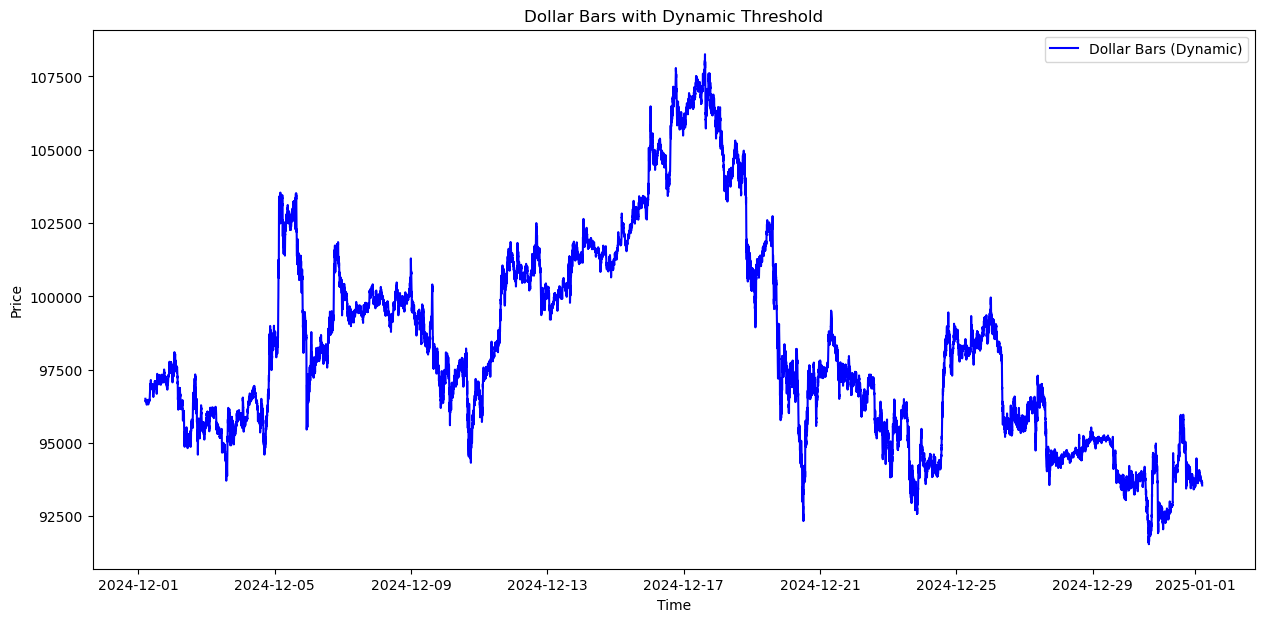

In [19]:
# plot dollar_bars_dyn
plt.figure(figsize=(15,7))
plt.plot(dollar_bars_dyn['close_time'], dollar_bars_dyn['close'], label='Dollar Bars (Dynamic)', color='blue')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Dollar Bars with Dynamic Threshold')
plt.legend()
plt.show()